In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import time

In [2]:
!nvidia-smi

Fri Oct 23 03:33:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |   2315MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   30C    P0    32W / 250W |   2385MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
from masks import grad_cam
from masks.meanpertrub import MeanPertrub

random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
CHECKPOINTS_DIR = '/home/Druzhinina/project/checkpoints/'
isTrain = True

In [4]:
X = np.load('/home/datasets/adni/tensors_cut.npz')
y = np.load('/home/datasets/adni/y_randomize.npy')

In [5]:
X = X.f.arr_0

In [6]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
#         sample = {'img': self.X[idx], 'landmarks': self.y[idx]}
#         if self.transform:
#                    sample = self.transform(sample)
        return self.X[idx], self.y[idx]

In [7]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=4*c*5*5*5, out_features=2),
        )
        self.gradients = None
        
  
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [8]:
if torch.cuda.is_available():
  device = torch.device("cuda:2")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [2]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [2] GPUs!


In [9]:
dataset = MriData(X, y, transform=None)

In [10]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

GradCam

In [14]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_NetGradRandomiz'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
    masks_grad = grad_cam.get_masks(model.module, loader, device, mask_type='grad_cam')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_randomize'), masks_grad)
else:
    masks_grad = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam.npy'))

100%|██████████| 517/517 [01:31<00:00,  5.62it/s]


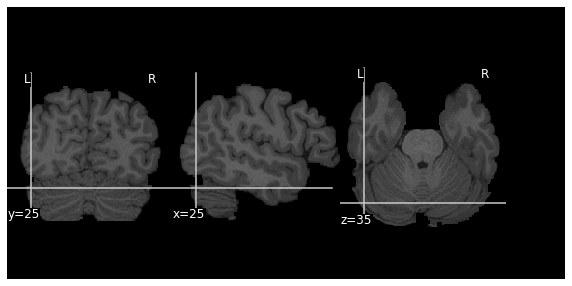

In [17]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.0000001)
plt.show()
# fig.savefig("grad_cam.png", bbox_inches='tight')

Guided Back-propagation

In [12]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_NetGradRandomiz'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
    masks_gb = grad_cam.get_masks(model.module, loader, device, mask_type='guided_backprop')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb_randomize'), masks_gb)
else:
    masks_gb =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb.npy'))

100%|██████████| 517/517 [08:45<00:00,  1.02s/it]


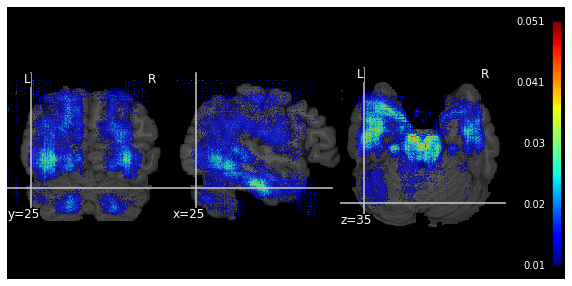

In [13]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb[y==1].mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.01)
plt.show()
fig.savefig("guided backpropagation.png", bbox_inches='tight')

In [11]:
masks_gb =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb.npy'))

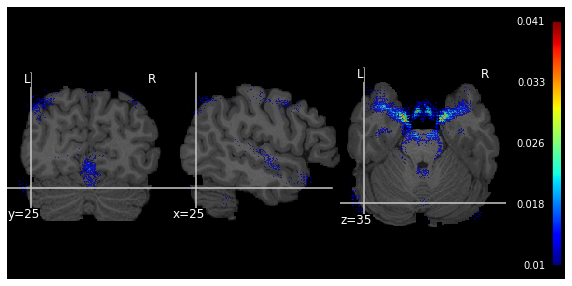

In [12]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb[y==1].mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.01)
plt.show()
fig.savefig("guided backpropagation.png", bbox_inches='tight')